<a href="https://colab.research.google.com/github/ymohamedahmed/drbayes/blob/master/SIBDL_demo_group_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Seminars - Subspace Inference for Bayesian Deep Learning - Demo

*Reviewed by Chiara Campagnola, Yousuf Mohamed-Ahmed and Hannah Teufel*

**Aims of this notebook**:
- Empirically evaluate the effectiveness of the uncertainty estimates produced (this is **not** evaluated by the paper)
- Evaluate the performance gains achieved by applying approximate inference techniques in subspaces *vs* in the full space
<!-- - Compare the method proposed by the paper to non-neural network based approaches -->

**Research questions**:
- In comparison to ensembles and 'full' variational inference (VI); how well does VI in PCA subspace perform in terms of uncertainty estimates (measured by [expected calibration error](https://arxiv.org/pdf/1706.04599.pdf) and out-of-distribution uncertainty estimates).
- Using the same comparisons, how does 'performance' of the paper stack up? 

## Setup

In [ ]:
!rm -rf drbayes
!git clone https://github.com/ymohamedahmed/drbayes.git

Cloning into 'drbayes'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 374 (delta 56), reused 56 (delta 21), pack-reused 261
Receiving objects: 100% (374/374), 15.36 MiB | 37.01 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
import sys
%pip install -e drbayes 

Obtaining file:///content/drbayes
  Found existing installation: subspace-inference 0.0
    Uninstalling subspace-inference-0.0:
      Successfully uninstalled subspace-inference-0.0
  Running setup.py develop for subspace-inference


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets, transforms

import seaborn as sns

import subspace_inference
import subspace_inference.utils as utils
from subspace_inference.posteriors import SWAG
from subspace_inference import models, losses, utils
from subspace_inference.models import MLP
from subspace_inference.visualization import plot_predictive
from subspace_inference.posteriors.proj_model import SubspaceModel
from tqdm.notebook import tqdm
from subspace_inference.posteriors.vi_model import VIModel, ELBO
import math

import os

torch.backends.cudnn.benchmark = True
INITIAL_SEED = 1
torch.manual_seed(INITIAL_SEED)
torch.cuda.manual_seed(INITIAL_SEED)
np.random.seed(INITIAL_SEED)

%load_ext autoreload
%autoreload 2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_all = datasets.QMNIST(root="../data",train=True, download=True,
                   transform=transform)
train_val_split = int(0.8*len(train_all))
train_idx, val_idx = range(0, train_val_split), range(train_val_split, len(train_all))

train = torch.utils.data.Subset(train_all, train_idx)
val = torch.utils.data.Subset(train_all, val_idx)
test = datasets.QMNIST('../data', train=False,download=True,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(train,batch_size=512)
val_loader = torch.utils.data.DataLoader(val,batch_size=len(val))



Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Processing...


### Helper code

In [ ]:
class VanillaMLP(nn.Module):
  def __init__(self, dims):
    super(VanillaMLP,self).__init__()
    self.dims = dims
    layers = [nn.Flatten()] + [lay for (x,y) in zip(dims[:-1],dims[1:]) for lay in [nn.Linear(x,y), nn.ReLU()] ]
    layers.pop()
    self.model = nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

In [ ]:
def celoss_acc(model, loss_function, loader):
  N = 0
  total_loss = 0
  acc = 0
  for (x,y) in loader:
    x = x.to(device)
    y = y.to(device)
    out = model(x)
    loss = loss_function(model,x,y)[0]
    total_loss += loss.item()
    acc += (out.argmax(dim=1)==y).sum().item()
    N += x.size(0)
  return total_loss/N, acc/N

def convergence(val_losses):
  return len(val_losses) > 10 and sum([val_losses[i] >= val_losses[i-1] for i in range(-1,-10,-1)])>5

def train(model, loss_function, max_epochs, train_loader, val_loader, lr, collect_model=False):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  vlosses = []
  if collect_model:
    swag_model = SWAG(VanillaMLP, subspace_type="pca",
                    subspace_kwargs={"max_rank": 10, "pca_rank": 10},dims=model.dims)
  pbar = tqdm(range(max_epochs))
  for epoch in pbar:
    for x,y in train_loader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      if collect_model: 
        swag_model.collect_model(model)
      loss = loss_function(model,x,y)[0]
      loss.backward()
      optimizer.step()
    vloss, vacc = celoss_acc(model, loss_function, val_loader)
    vlosses.append(vloss)

    # don't check convergence if simply collecting weights
    if convergence(vlosses) and not(collect_model):
      print("converged")
      break
    pbar.set_description(f'loss: {round(vloss,3)}, acc: {round(vacc,3)}')
    if epoch % 2 == 0:
        print(f"Epoch: {epoch}, loss: {vloss}, acc: {vacc}")

  if collect_model:
    return swag_model.get_space()

In [ ]:
def vi_pred(model, number_samples, test_loader, num_classes=10):
  preds = torch.zeros((len(test_loader.dataset), num_classes))
  for n, (x,_) in tqdm(enumerate(test_loader)):
    x = x.to(device)
    for i in range(number_samples):
      preds[n*test_batch_size:(n+1)*test_batch_size] += F.softmax(model(x).cpu(),dim=1)
    del x 
    torch.cuda.empty_cache()
  preds = 1/number_samples *preds
  acc = (1.*torch.argmax(preds, dim=1).eq(test_loader.dataset.targets[:,0])).mean()
  return preds, acc

In [ ]:
def number_of_params(dims):
  d = np.array(dims)
  return ((d[:-1]*d[1:])+d[1:]).sum()

def create_full_vi_model():
  init_sigma = 1.
  prior_sigma = 1.
  dims = [28*28,10]
  number_params = number_of_params(dims)
  identity_space = SubspaceModel(torch.zeros(number_params), torch.eye(number_params))
  mod = VIModel(
      subspace=identity_space,
      init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
      prior_log_sigma=math.log(prior_sigma),
      base=VanillaMLP,
      dims=dims
  )
  mod.to(device)
  return mod

In [ ]:
class Ensemble(nn.Module):
    
  def __init__(self, number_of_networks, dims):
    self.N = number_of_networks
    self.dims = dims
    self.ensemble = []
    for _ in range(number_of_networks):
       # change the seed otherwise all models will start with same init.
       self._new_seeds()
       self.ensemble.append(VanillaMLP(dims))
    self._reset_seeds()

  def _reset_seeds(self):
    torch.manual_seed(INITIAL_SEED)
    torch.cuda.manual_seed(INITIAL_SEED)
    np.random.seed(INITIAL_SEED)
  
  def _new_seeds(self):
    torch.manual_seed(torch.randint(high=256,size=(1,)).item())
    torch.cuda.manual_seed(torch.randint(high=256,size=(1,)).item())
    np.random.seed(torch.randint(high=256,size=(1,)).item())

  def train(self, loss_function, max_epochs, train_loader, val_loader, lr):
    for m in self.ensemble:
      m.to(device)
      self._new_seeds()
      train(m, loss_function, max_epochs, train_loader, val_loader, lr=lr)
    self._reset_seeds()
  
  def _single_predict(self, x):
    output = torch.zeros(self.dims[-1])
    for m in self.ensemble:
      output += m(x)
    return output/self.N
  
  def predict(self, loader):
    preds = torch.zeros(len(loader), self.dims[-1])
    for i, (x,y) in enumerate(loader):
      preds[i] = self._single_predict(x)
    return preds

  def save(self):
    for i in range(self.N):
      torch.save(self.ensemble[i].state_dict(), f'/content/drive/My Drive/sibdl/ensemble-{i}.pt')
    
  def load(self):
    for i in range(self.N):
      self.ensemble[i].load_state_dict(torch.load(f'/content/drive/My Drive/sibdl/ensemble-{i}.pt'))

In [ ]:
# run VI on the PCA-derived subspace
def create_vi_model(subspace):
  init_sigma = 1.
  prior_sigma = 5.
  criterion = losses.cross_entropy
  
  vi_model = VIModel(
      subspace=subspace,
      init_inv_softplus_sigma=math.log(math.exp(init_sigma) - 1.0),
      prior_log_sigma=math.log(prior_sigma),
      base=VanillaMLP,
      dims=[28*28,10]
  )
  
  vi_model.to(device)
  return vi_model


## Training the models (you can skip this!)
- Full VI 
- VI in PCA subspace 
- ensemble of NNs

### Mean Field Variational Inference

In [ ]:
full_vi_model = create_full_vi_model()
temperature = 1.
elbo = ELBO(losses.cross_entropy, len(train_loader.dataset), temperature=temperature)
train(full_vi_model, elbo, 500, train_loader, val_loader, lr=0.1)
torch.save(full_vi_model.state_dict(), "/content/drive/My Drive/sibdl/full-vi-pca-model.pt")

Epoch: 0, loss: 0.0004849621057510376, acc: 0.85825
Epoch: 2, loss: 0.00036828927199045815, acc: 0.8725833333333334
Epoch: 4, loss: 0.0003597204685211182, acc: 0.8875
Epoch: 6, loss: 0.0002725778023401896, acc: 0.881
Epoch: 8, loss: 0.00030416907866795856, acc: 0.8719166666666667
Epoch: 10, loss: 0.0002442347208658854, acc: 0.8970833333333333
Epoch: 12, loss: 0.0002535726030667623, acc: 0.89
Epoch: 14, loss: 0.0002333676020304362, acc: 0.8948333333333334
Epoch: 16, loss: 0.00026942274967829385, acc: 0.8713333333333333
Epoch: 18, loss: 0.00023447467883427938, acc: 0.8923333333333333
Epoch: 20, loss: 0.00028329739967981974, acc: 0.8808333333333334
Epoch: 22, loss: 0.00023154083887736001, acc: 0.8915833333333333
Epoch: 24, loss: 0.0002003459930419922, acc: 0.9029166666666667
Epoch: 26, loss: 0.00022897901137669882, acc: 0.8994166666666666
converged


### Ensembles

In [ ]:
ensemble = Ensemble(number_of_networks = 10, dims = [28*28,10])
ensemble.train(losses.cross_entropy, 500, train_loader, val_loader, lr=0.01)
ensemble.save()

Epoch: 0, loss: 2.5275332232316336e-05, acc: 0.9143333333333333
Epoch: 2, loss: 2.4666423598925272e-05, acc: 0.9191666666666667
Epoch: 4, loss: 2.5266659756501515e-05, acc: 0.9185
Epoch: 6, loss: 2.5910275677839915e-05, acc: 0.9173333333333333
Epoch: 8, loss: 2.6476919651031494e-05, acc: 0.91625
converged


Epoch: 0, loss: 2.533416450023651e-05, acc: 0.915
Epoch: 2, loss: 2.4844430387020112e-05, acc: 0.9188333333333333
Epoch: 4, loss: 2.54142756263415e-05, acc: 0.91775
Epoch: 6, loss: 2.602772911389669e-05, acc: 0.9170833333333334
Epoch: 8, loss: 2.6564190785090127e-05, acc: 0.91675
converged


Epoch: 0, loss: 2.5827467441558837e-05, acc: 0.913
Epoch: 2, loss: 2.4679186443487804e-05, acc: 0.9194166666666667
Epoch: 4, loss: 2.5405300160249075e-05, acc: 0.9186666666666666
Epoch: 6, loss: 2.6050736506779988e-05, acc: 0.9173333333333333
Epoch: 8, loss: 2.6593044400215148e-05, acc: 0.9156666666666666
converged


Epoch: 0, loss: 2.5270608564217886e-05, acc: 0.91475
Epoch: 2, loss: 2.489598592122396e-05, acc: 0.919
Epoch: 4, loss: 2.5448985397815704e-05, acc: 0.9176666666666666
Epoch: 6, loss: 2.602744847536087e-05, acc: 0.9174166666666667
Epoch: 8, loss: 2.6543234785397846e-05, acc: 0.91675
converged


Epoch: 0, loss: 2.5803687671820322e-05, acc: 0.9120833333333334
Epoch: 2, loss: 2.4680996934572856e-05, acc: 0.9188333333333333
Epoch: 4, loss: 2.533531685670217e-05, acc: 0.9180833333333334
Epoch: 6, loss: 2.595772345860799e-05, acc: 0.9169166666666667
Epoch: 8, loss: 2.649826556444168e-05, acc: 0.91625
converged


Epoch: 0, loss: 2.564952274163564e-05, acc: 0.9123333333333333
Epoch: 2, loss: 2.479808032512665e-05, acc: 0.9184166666666667
Epoch: 4, loss: 2.5414012372493744e-05, acc: 0.9186666666666666
Epoch: 6, loss: 2.602367103099823e-05, acc: 0.91725
Epoch: 8, loss: 2.655041217803955e-05, acc: 0.9165833333333333
converged


Epoch: 0, loss: 2.558326969544093e-05, acc: 0.9140833333333334
Epoch: 2, loss: 2.4909918506940206e-05, acc: 0.9189166666666667
Epoch: 4, loss: 2.550628036260605e-05, acc: 0.9179166666666667
Epoch: 6, loss: 2.6078037917613985e-05, acc: 0.9174166666666667
Epoch: 8, loss: 2.6578163107236226e-05, acc: 0.9165
converged


Epoch: 0, loss: 2.5464676320552827e-05, acc: 0.9144166666666667
Epoch: 2, loss: 2.5139883160591124e-05, acc: 0.91925
Epoch: 4, loss: 2.575375388065974e-05, acc: 0.9181666666666667
Epoch: 6, loss: 2.6269038518269858e-05, acc: 0.9166666666666666
Epoch: 8, loss: 2.6707728703816733e-05, acc: 0.9164166666666667
converged


Epoch: 0, loss: 2.5922134518623352e-05, acc: 0.9125
Epoch: 2, loss: 2.481287717819214e-05, acc: 0.9178333333333333
Epoch: 4, loss: 2.546661098798116e-05, acc: 0.917
Epoch: 6, loss: 2.6083310445149738e-05, acc: 0.9169166666666667
Epoch: 8, loss: 2.660437673330307e-05, acc: 0.9165833333333333
converged


Epoch: 0, loss: 2.567920337120692e-05, acc: 0.9128333333333334
Epoch: 2, loss: 2.480037013689677e-05, acc: 0.9190833333333334
Epoch: 4, loss: 2.548521508773168e-05, acc: 0.9175833333333333
Epoch: 6, loss: 2.610793709754944e-05, acc: 0.9173333333333333
Epoch: 8, loss: 2.6629172265529632e-05, acc: 0.9161666666666667
converged


### PCA subspace

In [ ]:
model = VanillaMLP([28*28,10])
model.to(device)

VanillaMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
# train model to convergence

train(model, losses.cross_entropy, 500, train_loader, val_loader, lr=0.001)

# train for a further number of epochs to collect PCA subspace
space = train(model, losses.cross_entropy, 200, train_loader, val_loader, lr=0.001, collect_model=True)
torch.save(model.state_dict(), "/content/drive/My Drive/sibdl/MLP-qmnist.pt")
mean, _, cov_factor = space
subspace = SubspaceModel(mean, cov_factor)
torch.save(subspace.state_dict(), "/content/drive/My Drive/sibdl/pca-subspace-qmnist.pt")

Epoch: 0, loss: 3.324992209672928e-05, acc: 0.8956666666666667
Epoch: 2, loss: 2.5866739451885224e-05, acc: 0.9148333333333334
Epoch: 4, loss: 2.4122968316078186e-05, acc: 0.9205
Epoch: 6, loss: 2.3373591403166454e-05, acc: 0.9225
Epoch: 8, loss: 2.297955999771754e-05, acc: 0.92375
Epoch: 10, loss: 2.2752498586972556e-05, acc: 0.92475
Epoch: 12, loss: 2.261671672264735e-05, acc: 0.9251666666666667
Epoch: 14, loss: 2.253587543964386e-05, acc: 0.9260833333333334
Epoch: 16, loss: 2.2490233182907106e-05, acc: 0.92675
Epoch: 18, loss: 2.24681223432223e-05, acc: 0.9275833333333333
Epoch: 20, loss: 2.246218423048655e-05, acc: 0.928
Epoch: 22, loss: 2.2467566033204398e-05, acc: 0.9278333333333333
Epoch: 24, loss: 2.2480939825375874e-05, acc: 0.92775
converged


Epoch: 0, loss: 2.2499787310759226e-05, acc: 0.9270833333333334
Epoch: 2, loss: 2.2538368900616963e-05, acc: 0.9275833333333333
Epoch: 4, loss: 2.2570071121056875e-05, acc: 0.9275
Epoch: 6, loss: 2.2601827979087828e-05, acc: 0.92775
Epoch: 8, loss: 2.263371149698893e-05, acc: 0.92775
Epoch: 10, loss: 2.266569435596466e-05, acc: 0.92775
Epoch: 12, loss: 2.2697662313779195e-05, acc: 0.9275
Epoch: 14, loss: 2.272953341404597e-05, acc: 0.92725
Epoch: 16, loss: 2.276123563448588e-05, acc: 0.9273333333333333
Epoch: 18, loss: 2.2792714337507885e-05, acc: 0.9275833333333333
Epoch: 20, loss: 2.2823902467886606e-05, acc: 0.9273333333333333
Epoch: 22, loss: 2.2854775190353394e-05, acc: 0.9270833333333334
Epoch: 24, loss: 2.2885310153166454e-05, acc: 0.9269166666666667
Epoch: 26, loss: 2.2915480037530264e-05, acc: 0.9269166666666667
Epoch: 28, loss: 2.294526994228363e-05, acc: 0.927
Epoch: 30, loss: 2.297468235095342e-05, acc: 0.9268333333333333
Epoch: 32, loss: 2.3003699878851572e-05, acc: 0.9267

In [ ]:
vi_model = create_vi_model(subspace)
temperature = 1.
elbo = ELBO(losses.cross_entropy, len(train_loader.dataset), temperature=temperature)
train(vi_model, elbo, 500, train_loader, val_loader, lr=0.001)
torch.save(vi_model.state_dict(), "/content/drive/My Drive/sibdl/vi-pca-model.pt")

Epoch: 0, loss: 2.5003763536612192e-05, acc: 0.9235833333333333
Epoch: 2, loss: 2.3306620617707572e-05, acc: 0.9273333333333333
Epoch: 4, loss: 2.2917407254378e-05, acc: 0.9281666666666667
Epoch: 6, loss: 2.3281546930472055e-05, acc: 0.9273333333333333
Epoch: 8, loss: 2.310450126727422e-05, acc: 0.9253333333333333
Epoch: 10, loss: 2.3160678644975026e-05, acc: 0.92825
converged


## Running Ensembles, PCA subspace and full VI

Let's load the old models

In [ ]:
full_vi_model = create_full_vi_model()
full_vi_model.load_state_dict(torch.load('/content/drive/My Drive/sibdl/full-vi-pca-model.pt'))

ensemble = Ensemble(10, [28*28,10])
ensemble.load()

mean,cov_factor = torch.zeros(7850), torch.zeros(10,7850)
subspace = SubspaceModel(mean, cov_factor)
subspace.load_state_dict(torch.load("/content/drive/My Drive/sibdl/pca-subspace-qmnist.pt"))
vi_model = create_vi_model(subspace)

#### Full VI


tensor([0.3141, 0.3308, 0.3322, 0.3353, 0.3464, 0.3468, 0.3469, 0.3470, 0.3500,
        0.3504, 0.3530, 0.3540, 0.3545, 0.3569, 0.3582, 0.3587, 0.3649, 0.3649,
        0.3663, 0.3708], grad_fn=<IndexBackward>)


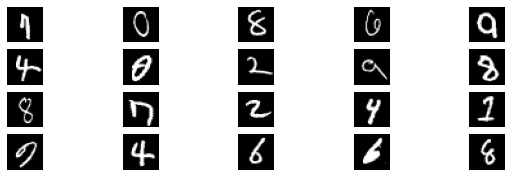

In [ ]:
test_batch_size = 512
test_loader = torch.utils.data.DataLoader(test,batch_size=test_batch_size)
full_vi_preds,acc = vi_pred(full_vi_model, 100, test_loader)
inds = torch.max(full_vi_preds,dim=1)[0].argsort()[:20]
print(torch.max(full_vi_preds,dim=1)[0][inds])
fig,axs = plt.subplots(figsize=(10,3),nrows=4, ncols=5)
axs = axs.flatten()
for i,im in enumerate(test_loader.dataset.data[inds]):
  ax = axs[i]
  ax.imshow(im,cmap='gray')
  ax.set_axis_off()
  # ax.title.set_text(f'predicted: {full_vi_preds[i].argmax()}')
# plt.title("Full Variational Inference")
plt.savefig('full-vi.png')
plt.show()

### PCA subspace

tensor([0.2090, 0.2255, 0.2269, 0.2374, 0.2504, 0.2544, 0.2577, 0.2617, 0.2620,
        0.2652, 0.2700, 0.2702, 0.2709, 0.2723, 0.2751, 0.2751, 0.2762, 0.2776,
        0.2778, 0.2793], grad_fn=<IndexBackward>)


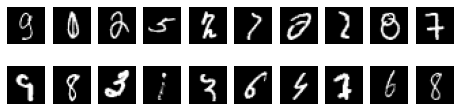

In [ ]:
test_batch_size = 512
test_loader = torch.utils.data.DataLoader(test,batch_size=test_batch_size)
# vi_preds,acc = vi_pred(vi_model, 100, test_loader)
inds = torch.max(vi_preds,dim=1)[0].argsort()[:20]
print(torch.max(vi_preds,dim=1)[0][inds])
fig,axs = plt.subplots(figsize=(8,2),nrows=2, ncols=10)
axs = axs.flatten()
for i,im in enumerate(test_loader.dataset.data[inds]):
  ax = axs[i]
  ax.imshow(im,cmap='gray')
  ax.set_axis_off()
  # ax.title.set_text(f'predicted: {vi_preds[i].argmax()}')
# plt.title("Variational Inference in PCA subspace with 10 dimensions")
plt.savefig("vi.pdf")
plt.show()

### Ensemble

In [ ]:
# test_loader = torch.utils.data.DataLoader(test,batch_size=1)
# ensemble_preds = torch.zeros(len(test_loader), 10)

# for i, (x,y) in enumerate(test_loader):
#   x = x.to(device)
#   output = torch.zeros(1,10).to(device)
#   for m in ensemble.ensemble:
#     m.to(device)
#     output += F.softmax(m(x), dim=1)
#   ensemble_preds[i] = output/ensemble.N

inds = torch.max(ensemble_preds,dim=1)[0].argsort()[:20]
print(torch.max(ensemble_preds,dim=1)[0][inds])
fig,axs = plt.subplots(figsize=(5,2),nrows=4, ncols=5)
axs = axs.flatten()
for i,im in enumerate(test_loader.dataset.data[inds]):
  ax = axs[i]
  ax.imshow(im,cmap='gray')
  ax.set_axis_off()
  # ax.title.set_text(f'predicted: {ensemble_preds[i].argmax()}')
plt.savefig("ensemble.png")
plt.show()

NameError: ignored

### Which gives the 'best' uncertainty?

In [ ]:
def ece(predictions, y, bins=10):
  preds = predictions.argmax(dim=1)
  confidences = predictions.max(dim=1)[0]
  l = np.linspace(0,1,bins+1)
  ece = torch.zeros(bins)
  accs = torch.zeros(bins)
  confs = torch.zeros(bins)
  N = y.size(0)
  for ind, (lower,upper) in enumerate(zip(l[:-1], l[1:])):
    indxs = torch.logical_and((confidences<upper),(confidences>=lower))
    acc = (1.*(preds[indxs] == y[indxs])).mean().item()
    conf = confidences[indxs].mean().item()
    ece[ind] = ((1.*indxs).sum().item()/N) * np.abs(acc-conf)
    accs[ind], confs[ind] = acc, conf
  return ece.nansum(), accs, confs


In [ ]:
def plot_ece(confs, label):
  width=0.1
  fig, ax = plt.subplots(figsize=(5,5))
  ax.bar(np.linspace(0,.9,10)+.05, confs, width=width, label=label)
  ax.plot(np.linspace(0,1,11),np.linspace(0,1,11),linestyle='--',label='Perfect uncert.', color='red')
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Confidence")
  plt.legend()
  plt.savefig(label.replace(" ","-") + ".pdf")
  plt.show()

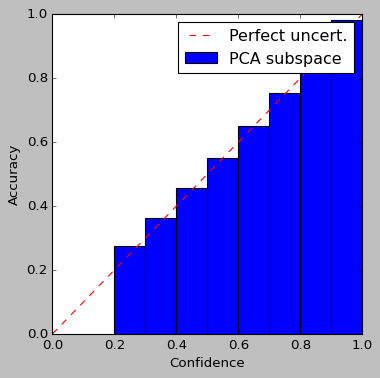

tensor(0.0037)
tensor([   nan,    nan, 0.3000, 0.3437, 0.4303, 0.5379, 0.6693, 0.7652, 0.8675,
        0.9829])
tensor([   nan,    nan, 0.2762, 0.3615, 0.4576, 0.5505, 0.6514, 0.7525, 0.8558,
        0.9825])


"\nece_score,accs, conf = ece(full_vi_preds, test.targets[:,0])\nprint(ece_score)\nplot_ece(conf, label=f'Full VI subspace')\nece_score, accs, conf = ece(ensemble_preds, test.targets[:,0])\nprint(ece_score)\nplot_ece(conf, label=f'Ensemble')\n"

In [ ]:
plt.style.use('classic')
ece_score, accs, conf = ece(vi_preds, test.targets[:,0])
plot_ece(conf, label=f'PCA subspace')
print(ece_score)
print(accs)
print(conf)
'''
ece_score,accs, conf = ece(full_vi_preds, test.targets[:,0])
print(ece_score)
plot_ece(conf, label=f'Full VI subspace')
ece_score, accs, conf = ece(ensemble_preds, test.targets[:,0])
print(ece_score)
plot_ece(conf, label=f'Ensemble')
'''

## _References_

- A very useful repository for a lot of Bayesian NN implementations: https://github.com/JavierAntoran/Bayesian-Neural-Networks
- The code for the paper is found at https://github.com/wjmaddox/drbayes and specifically the following notebook was adapted for this demonstration (https://github.com/wjmaddox/drbayes/blob/master/experiments/synthetic_regression/visualizing_uncertainty.ipynb)


In [ ]:
!git config --global user.email "youmed.tech@gmail.com"
!git config --global user.name "ymohamedahmed"
!git --git-dir=drbayes/.git add -f drbayes/*.pt
!git --git-dir=drbayes/.git commit -m "updated checkpoints"
!git --git-dir=drbayes/.git push
# !cd ../

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
	deleted:    .gitignore
	deleted:    435_supplement.pdf
	deleted:    LICENSE
	deleted:    MLP-qmnist.pt
	deleted:    README.md
	deleted:    SIBDL_demo_group_13.ipynb
	deleted:    experiments/cifar_exps/README.md
	deleted:    experiments/cifar_exps/subspace_ess.py
	deleted:    experiments/cifar_exps/subspace_vi.py
	deleted:    experiments/cifar_exps/swag.py
	deleted:    experiments/data/MNIST/raw/train-images-idx3-ubyte
	deleted:    experiments/synthetic_regression/SIBDL-demo-group-13.ipynb
	deleted:    experiments/synthetic_regression/ckpts/curve.pt
	deleted:    experiments/synthetic_regression/ckpts/curve_parameters.npy
	deleted:    experiments/synthetic_regression/ckpts/data.npy
	deleted:    experiments/synthetic_regression/ckpts/sgd_checkpoint1.pt
	deleted:    experiments/synthetic_regression/ckpts/sgd_checkpoint2.pt
	deleted:    expe

In [ ]:
!git --git-dir=drbayes/.git push

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
del preds
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
